In [41]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/datakiemtra/data-kiem-tra-1.csv


In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from pykalman import KalmanFilter

In [43]:
df = pd.read_csv('/kaggle/input/datakiemtra/data-kiem-tra-1.csv')
df.head(10)

,date,truong_1,truong_2,truong_3,truong_4,truong_5
0,02.01.2013,0,59,22154,999.00,1
1,03.01.2013,0,25,2552,899.00,1
2,05.01.2013,0,25,2552,899.00,-1
3,06.01.2013,0,25,2554,1709.05,1
4,15.01.2013,0,25,2555,1099.00,1
5,10.01.2013,0,25,2564,349.00,1
6,02.01.2013,0,25,2565,549.00,1
7,04.01.2013,0,25,2572,239.00,1
8,11.01.2013,0,25,2572,299.00,1
9,03.01.2013,0,25,2573,299.00,3


In [44]:
df.describe()

,truong_1,truong_2,truong_3,truong_4,truong_5
count,481822.000000,481822.000000,481822.000000,481822.000000,481822.000000
mean,1.664279,31.189028,10117.416973,685.990926,1.169633
std,1.271877,15.804208,6282.731587,1113.175961,0.916869
min,0.000000,0.000000,12.000000,3.000000,-6.000000
25%,1.000000,22.000000,4474.000000,203.000000,1.000000
50%,2.000000,29.000000,9348.000000,399.000000,1.000000
75%,3.000000,44.000000,15256.000000,699.000000,1.000000
max,4.000000,59.000000,22168.000000,32990.000000,88.000000


<Axes: >

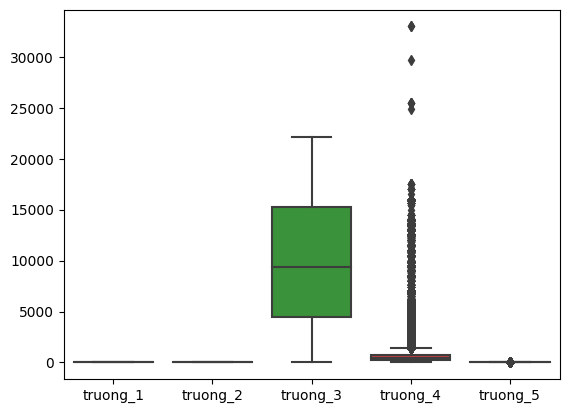

In [45]:
sns.boxplot(df)

In [46]:
IQR = df["truong_4"].quantile(0.75) - df["truong_4"].quantile(0.25)
lower_fare_limit = df["truong_4"].quantile(0.25) - (IQR* 1.5)
upper_fare_limit = df["truong_4"].quantile(0.75) + (IQR* 1.5)
print(lower_fare_limit)
print(upper_fare_limit)

-541.0
1443.0


In [47]:
df["truong_4"]= np.where(df["truong_4"] > upper_fare_limit, upper_fare_limit,np.where(df["truong_4"] < lower_fare_limit,lower_fare_limit, df["truong_4"]))

<Axes: >

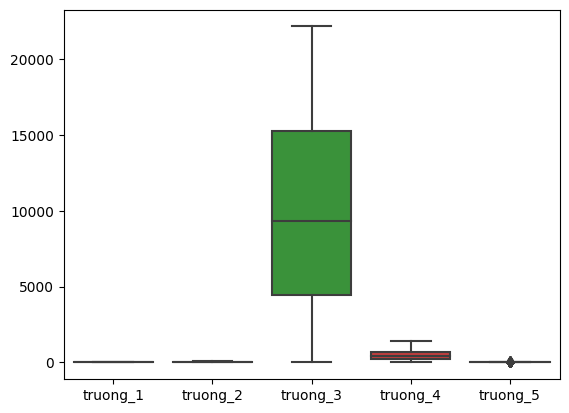

In [48]:
sns.boxplot(df)

In [49]:
IQR = df["truong_5"].quantile(0.75) - df["truong_5"].quantile(0.25)
lower_fare_limit = df["truong_5"].quantile(0.25) - (IQR* 1.5)
upper_fare_limit = df["truong_5"].quantile(0.75) + (IQR* 1.5)
print(lower_fare_limit)
print(upper_fare_limit)

1.0
1.0


In [50]:
df["truong_5"]= np.where(df["truong_5"] > upper_fare_limit, upper_fare_limit,np.where(df["truong_5"] < lower_fare_limit,lower_fare_limit, df["truong_5"]))

<Axes: >

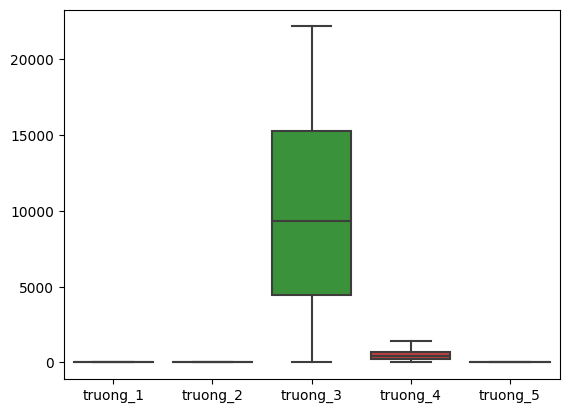

In [51]:
sns.boxplot(df)

In [52]:
df.isnull().sum()

date        0
truong_1    0
truong_2    0
truong_3    0
truong_4    0
truong_5    0
dtype: int64

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 481822 entries, 0 to 481821
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   date      481822 non-null  object 
 1   truong_1  481822 non-null  int64  
 2   truong_2  481822 non-null  int64  
 3   truong_3  481822 non-null  int64  
 4   truong_4  481822 non-null  float64
 5   truong_5  481822 non-null  float64
dtypes: float64(2), int64(3), object(1)
memory usage: 22.1+ MB


In [54]:
# Chuyển đổi cột 'date' thành định dạng thời gian
df['date'] = pd.to_datetime(df['date'], format='%d.%m.%Y')

In [55]:
# Sắp xếp dữ liệu theo thứ tự thời gian
df = df.sort_values('date')
df.head(10)

,date,truong_1,truong_2,truong_3,truong_4,truong_5
85124,2013-01-01,0,54,11562,299.00,1.0
21841,2013-01-01,0,28,18381,149.00,1.0
17861,2013-01-01,0,28,3976,299.00,1.0
91432,2013-01-01,0,42,16993,397.92,1.0
50169,2013-01-01,0,18,19368,198.00,1.0
85209,2013-01-01,0,54,11246,149.00,1.0
82184,2013-01-01,0,54,4982,299.00,1.0
21833,2013-01-01,0,28,18350,199.00,1.0
82143,2013-01-01,0,54,5445,148.00,1.0
85235,2013-01-01,0,54,11184,199.00,1.0


In [58]:
# Chọn cột 'truong_4' để lọc
time_series = df['truong_4'].values

# Áp dụng bộ lọc Kalman
kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1)
state_means, _ = kf.filter(time_series)

# Chuyển đổi lại thành DataFrame
filtered_data = pd.DataFrame({'date': df['date'], 'filtered_truong_4': state_means.ravel()})

In [59]:
# Lấy dữ liệu đã lọc
time_series_filtered = filtered_data['filtered_truong_4'].values

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
time_series_scaled = scaler.fit_transform(time_series_filtered.reshape(-1, 1))

# Chuẩn bị dữ liệu cho mô hình
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 10
X, Y = create_dataset(time_series_scaled, look_back)

# Chuyển đổi dữ liệu thành tensor của PyTorch
X = torch.tensor(X, dtype=torch.float32).reshape(-1, look_back, 1)
Y = torch.tensor(Y, dtype=torch.float32).reshape(-1, 1)


In [60]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

input_size = 1
hidden_size = 50
output_size = 1

model = LSTM(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

num_epochs = 20
for epoch in range(num_epochs):
    outputs = model(X)
    optimizer.zero_grad()
    loss = criterion(outputs, Y)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [5/20], Loss: 0.0512
Epoch [10/20], Loss: 0.0514
Epoch [15/20], Loss: 0.0428
Epoch [20/20], Loss: 0.0395


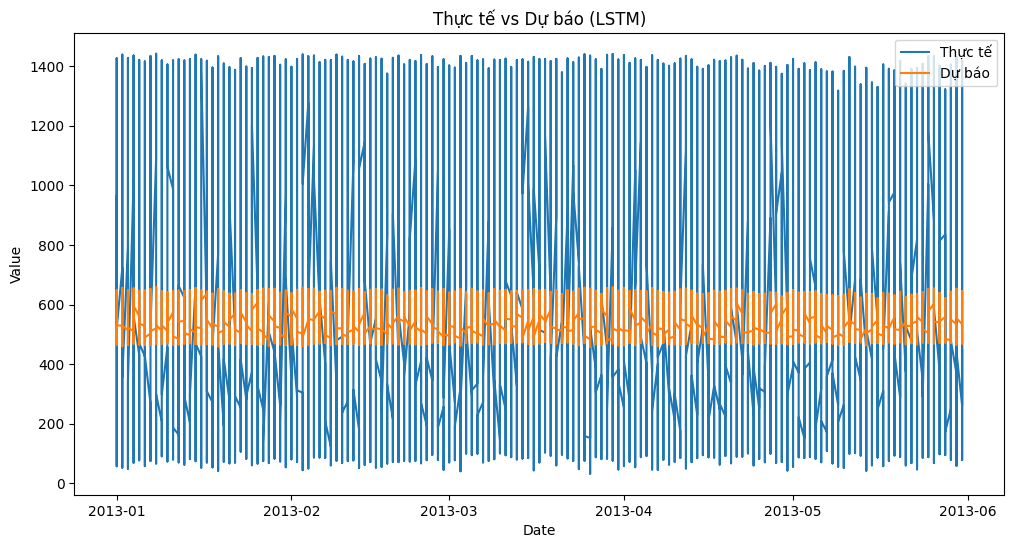

In [61]:
# Dự báo
model.eval()
with torch.no_grad():
    train_predict = model(X).detach().numpy()

train_predict = scaler.inverse_transform(train_predict)
Y_true = scaler.inverse_transform(Y)

# Vẽ đồ thị
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(filtered_data['date'][look_back + 1:len(Y_true) + look_back + 1], Y_true, label='Thực tế')
plt.plot(filtered_data['date'][look_back + 1:len(train_predict) + look_back + 1], train_predict, label='Dự báo')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Thực tế vs Dự báo (LSTM)')
plt.legend()
plt.show()


In [62]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

model_rnn = RNN(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model_rnn.parameters(), lr=0.01)

num_epochs = 20
for epoch in range(num_epochs):
    outputs = model_rnn(X)
    optimizer.zero_grad()
    loss = criterion(outputs, Y)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [5/20], Loss: 0.0460
Epoch [10/20], Loss: 0.0402
Epoch [15/20], Loss: 0.0386
Epoch [20/20], Loss: 0.0375


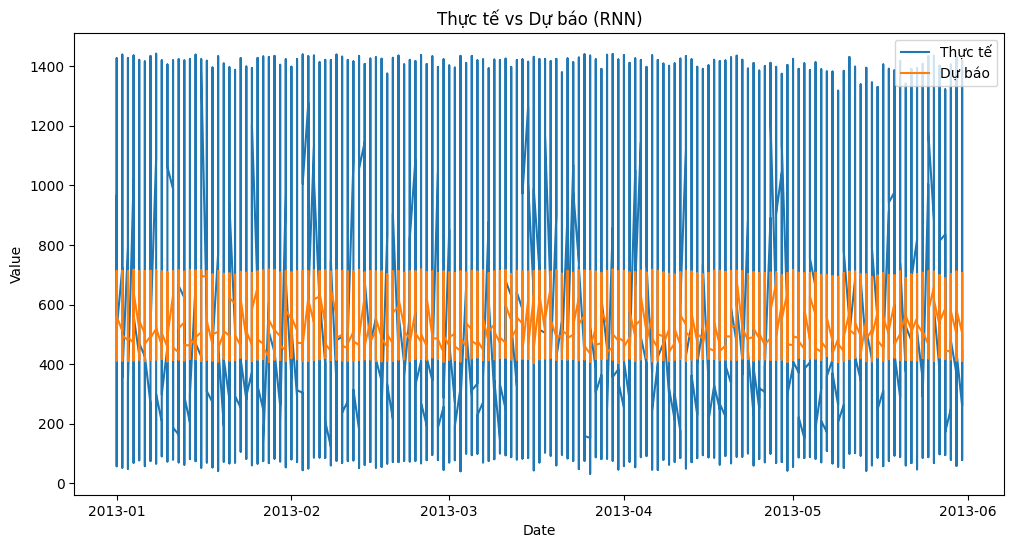

In [63]:
# Dự báo
model_rnn.eval()
with torch.no_grad():
    train_predict_rnn = model_rnn(X).detach().numpy()

train_predict_rnn = scaler.inverse_transform(train_predict_rnn)

# Vẽ đồ thị
plt.figure(figsize=(12, 6))
plt.plot(filtered_data['date'][look_back + 1:len(Y_true) + look_back + 1], Y_true, label='Thực tế')
plt.plot(filtered_data['date'][look_back + 1:len(train_predict_rnn) + look_back + 1], train_predict_rnn, label='Dự báo')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Thực tế vs Dự báo (RNN)')
plt.legend()
plt.show()